In [33]:
%pylab inline
import json
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Pipeline

1. Replace events with non-negative SVFit mass with appropriate distribution values (Z mass for Z->tautau events, H mass for H->tautau events, others retain their existing values)
2. Re-train the BDT for each value of $\sigma$ (peak resolution)
3. Evaluate the BDT on the holdout set and obtain the Z->tautau rejection rate at different signal efficiency points, along with the AUC

In [12]:
sigmaFactors = np.linspace(0,0.3,50)

In [9]:
df = pd.read_pickle("../../Preselection/output/HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_with_genZ.pkl")
with open("../../Preselection/output/HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_with_genZ.json") as f:
    input_options = json.load(f)

In [45]:
df = pd.read_pickle("../../Preselection/output/HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_with_genZ.pkl")
numVHEvents = len(df.loc[(df["process_id"] == 9) & (df["m_tautauSVFitLoose"] > 0)])
numHHEvents = len(df.loc[(df["process_id"] == -1) & (df["m_tautauSVFitLoose"] > 0)])
for idx, sigmaFactor in enumerate(sigmaFactors, 1):
    df = pd.read_pickle("../../Preselection/output/HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_with_genZ.pkl")
    print("index = {}, Current sigma factor = {}".format(idx, sigmaFactor))
    sigmaZ = sigmaFactor * 91
    sigmaH = sigmaFactor * 125
    VHMassSample = np.random.normal(91, sigmaZ, numVHEvents)
    HHMassSample = np.random.normal(125, sigmaH, numHHEvents)
    while any(VHMassSample < 0):
        VHMassSample[VHMassSample < 0] = np.random.normal(91, sigmaZ, sum(VHMassSample < 0))
    while any(HHMassSample < 0):
        HHMassSample[HHMassSample < 0] = np.random.normal(125, sigmaH, sum(HHMassSample < 0))
        
    df.loc[(df["process_id"] == 9) & (df["m_tautauSVFitLoose"] > 0), "m_tautauSVFitLoose"] = VHMassSample
    df.loc[(df["process_id"] == -1) & (df["m_tautauSVFitLoose"] > 0), "m_tautauSVFitLoose"] = HHMassSample
    
    sigmaFactorSaveValue = ("{0:0.3f}".format(sigmaFactor)).replace(".","p")
    save_filename = "HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_{}".format(sigmaFactorSaveValue)
    df.to_pickle(save_filename+".pkl")
    with open(save_filename+".json", "w") as fout:
        json.dump(input_options, fout)

index = 1, Current sigma factor = 0.0
index = 2, Current sigma factor = 0.006122448979591836
index = 3, Current sigma factor = 0.012244897959183673
index = 4, Current sigma factor = 0.01836734693877551
index = 5, Current sigma factor = 0.024489795918367346
index = 6, Current sigma factor = 0.030612244897959183
index = 7, Current sigma factor = 0.03673469387755102
index = 8, Current sigma factor = 0.04285714285714286
index = 9, Current sigma factor = 0.04897959183673469
index = 10, Current sigma factor = 0.055102040816326525
index = 11, Current sigma factor = 0.061224489795918366
index = 12, Current sigma factor = 0.0673469387755102
index = 13, Current sigma factor = 0.07346938775510203
index = 14, Current sigma factor = 0.07959183673469387
index = 15, Current sigma factor = 0.08571428571428572
index = 16, Current sigma factor = 0.09183673469387754
index = 17, Current sigma factor = 0.09795918367346938
index = 18, Current sigma factor = 0.10408163265306122
index = 19, Current sigma fact

In [54]:
%%bash
for f in *.pkl; do
    python ../../MVAs/prep.py --input $f --debug 1 --config ../../MVAs/data/HH_ggTauTau_signal_vs_all_resonant_BDT.json --output ${f%.*}.hdf5
done

[PrepHelper] Creating PrepHelper instance with options:
input='HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p000.pkl'
debug=1
config='../../MVAs/data/HH_ggTauTau_signal_vs_all_resonant_BDT.json'
output='HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p000.hdf5'
[PrepHelper] process_id map:  {'Data': 0, 'DiPhoton': 3, 'GJets_HT-100To200': 8, 'GJets_HT-200To400': 8, 'GJets_HT-400To600': 8, 'GJets_HT-600ToInf': 8, 'GJets_HT40To100': 8, 'HH_ggTauTau': -1, 'HH_ggWW_dileptonic': -3, 'HH_ggWW_semileptonic': -4, 'HH_ggZZ': -2, 'TTGG': 7, 'TTGamma': 6, 'TTbar': 5, 'VBFH': 12, 'VH': 9, 'WGamma': 4, 'ZGamma': 2, 'ggH': 11, 'ttH': 10}
[PrepHelper] Loaded file HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p000.pkl, containing 956810 events
[PrepHelper] After selecting for signals and backgrounds, dataframe contains 956810 events
[PrepHelper] After labeling, have 807661 

In [57]:
%%bash
for f in *.hdf5; do
    python ../../MVAs/train.py --input $f --debug 1  --config ../../MVAs/data/HH_ggTauTau_signal_vs_all_resonant_BDT.json --output_tag ${f%.*}
done

[MVAHelper] Creating MVAHelper instance with options:
input='HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p000.hdf5'
config='../../MVAs/data/HH_ggTauTau_signal_vs_all_resonant_BDT.json'
debug=1
output_tag='HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p000'
[MVAHelper] For set: train and label: signal, loaded 2657.899658 (269013) weighted (raw) events
[MVAHelper] For set: train and label: background, loaded 2716.690918 (49817) weighted (raw) events
[MVAHelper] For set: test and label: signal, loaded 2657.937500 (269200) weighted (raw) events
[MVAHelper] For set: test and label: background, loaded 2698.026123 (49678) weighted (raw) events
[BDTHelper] Training BDT with options:
{'max_depth': 10, 'eta': 0.3, 'nthread': 12, 'objective': 'binary:logistic', 'eval_metric': 'auc'}
[BDTHelper] early stopping with 8 rounds (2000 maximum)
[0]	train-auc:0.94548	test-auc:0.94109
[1]	train-auc:0.94985	test-auc:0

In [59]:
%%bash
for f in *.pkl; do
    python ../../MVAs/zip_mva_scores.py --input $f --mvas output/${f%.*}.json --names mva_score --output output/${f%.*}_zipped.pkl --debug 1
done

[ZipHelper] Creating ZipHelper instance with options:
input='HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p000.pkl'
mvas='output/HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p000.json'
names='mva_score'
output='output/HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p000_zipped.pkl'
debug=1
[ZipHelper] Loaded file HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p000.pkl, containing 956810 events
[ZipHelper] Creating ZipHelper instance with options:
input='HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p006.pkl'
mvas='output/HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p006.json'
names='mva_score'
output='output/HHggTauTau_InclusivePresel_genZStudy_20210506_resonant_backgrounds_sim_mass_sigma_factor_0p006_zipped.pkl'
debug=1
[ZipH

   ### Import the zipped files and extract ZH (Z$\rightarrow$ $\tau \tau$) efficiency at different signal efficiency points

In [61]:
import glob
zipped_files_list = glob.glob("output/*.pkl")

In [72]:
from yahist import Hist1D
def extract_VH_efficiency(df, signal_efficiencies):
    if type(signal_efficiencies) is not list:
        signal_efficiencies = [signal_efficiencies]
        
    # Get the working point
    val_df = df.loc[df["train_label"] == 2]
    val_df_signal = val_df.loc[val_df["process_id"] == -1]
    val_df_ZTauTauBG = val_df.loc[(val_df["process_id"] == 9) & (val_df["genZ_decayMode"] == 3)]
    #val_df_ggH = val_df.loc[(val_df[""])]
    signal_hist = Hist1D(val_df_signal["mva_score"].values, bins = np.linspace(0,1,20), weights = val_df_signal["weight"], label = "signal")
    ZToTauTau_hist = Hist1D(val_df_ZTauTauBG["mva_score"].values, bins = np.linspace(0,1,20), weights = val_df_ZTauTauBG["weight"], label = "ZTauTau")
    
    ZToTauTau_efficiencies = []
    for signal_efficiency in signal_efficiencies:
        working_point = signal_hist.quantile(1 - signal_efficiency)
        ZToTauTau_efficiencies.append(ZToTauTau_hist.restrict(0, working_point).integral/ZToTauTau_hist.integral)
    
    return list(zip(signal_efficiencies, ZToTauTau_efficiencies))
        

    

In [75]:
import glob
signal_efficiencies = [0.25, 0.5, 0.75, 0.9, 0.95]
background_efficiencies = {} # key = sigmaFactor, value = list returned by the extract function
for idx,zippedFile in enumerate(glob.glob("output/*.pkl"), 1):
    print("file number = ",idx)
    sigmaFactorString = zippedFile.split(".pkl")[0].split("_")[-2]
    sigmaFactor = float(sigmaFactorString.replace("p","."))
    background_efficiencies[sigmaFactor] = extract_VH_efficiency(pd.read_pickle(zippedFile), signal_efficiencies)

file number =  1
file number =  2
file number =  3
file number =  4
file number =  5
file number =  6
file number =  7
file number =  8
file number =  9
file number =  10
file number =  11
file number =  12
file number =  13
file number =  14
file number =  15
file number =  16
file number =  17
file number =  18
file number =  19
file number =  20
file number =  21
file number =  22
file number =  23
file number =  24
file number =  25
file number =  26
file number =  27
file number =  28
file number =  29
file number =  30
file number =  31
file number =  32
file number =  33
file number =  34
file number =  35
file number =  36
file number =  37
file number =  38
file number =  39
file number =  40
file number =  41
file number =  42
file number =  43
file number =  44
file number =  45
file number =  46
file number =  47
file number =  48
file number =  49
file number =  50


In [78]:
with open("background_efficiencies.txt","w") as f:
    print(background_efficiencies, file = f)

In [80]:
# recast based on signal efficiency

In [88]:
background_efficiencies_recast = {}
working_points = background_efficiencies.keys()
for signal_efficiency in signal_efficiencies:
    background_efficiencies_recast[signal_efficiency] = []
    for working_point, data in background_efficiencies.items():
        for candidate_signal_efficiency, candidate_background_efficiency in data:
            if candidate_signal_efficiency == signal_efficiency:
                background_efficiencies_recast[signal_efficiency] .append(candidate_background_efficiency)

In [89]:
background_efficiencies_recast

{0.25: [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 0.5: [0.985186585256078,
  1.0,
  1.0,
  0.9901418305607679,
  0.9737110248854042,
  1.0,
  0.9835240094625086,
  0.9806000149606482,
  0.9892617896478456,
  0.9838799816856595,
  0.983453419028163,
  0.9841907690466827,
  0.9786662701900939,
  0.9663106689064976,
  0.9676172724769163,
  0.9443355850846357,
  0.9336846945648583,
  0.948192415047706,
  0.9309287965296185,
  0.9464338432475728,
  0.9370428614103753,
  0.9082082198207172,
  0.920157570919086,
  0.9236305065005764,
  0.9254119073591897,
  0.8747200004522137,
  0.8858817235699862,
  0.9232039438430799,
  0.8793735781077514,
  0.8832527638744693,
  0.8525935495617623,
  0.8

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


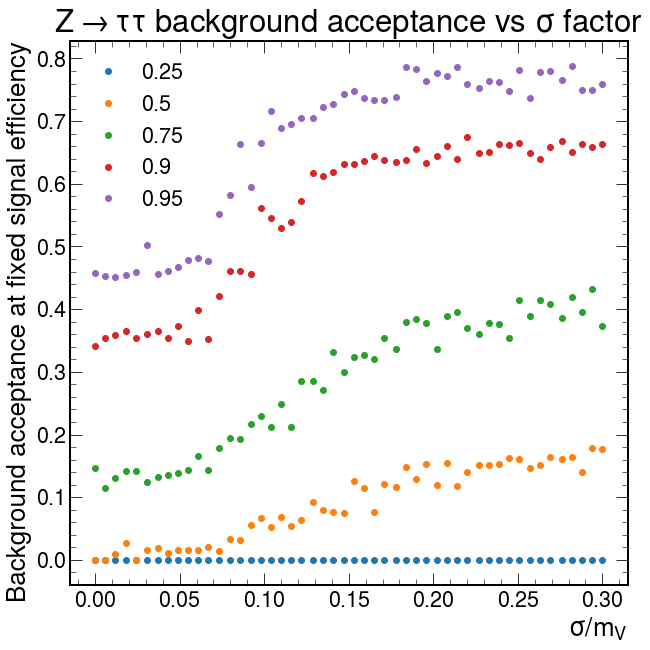

In [109]:
import mplhep as hep
plt.style.use([hep.style.CMS, hep.style.firamath])
#yscale("log")
for signal_efficiency in signal_efficiencies:
    plot(working_points, 1 - np.array(background_efficiencies_recast[signal_efficiency]), "o", label = signal_efficiency)
plt.xlabel(r"$\sigma$/$m_V$")
plt.ylabel("Background acceptance at fixed signal efficiency")
plt.legend()
plt.title(r"Z$\rightarrow\tau\tau$ background acceptance vs $\sigma$ factor")
plt.savefig("bg_v_sigma.pdf")

In [111]:
%%bash
cp bg_v_sigma.pdf /home/users/bsathian/public_html/HHGGTauTau_plots/bg_v_sigma_linear_scale.pdf
chmod 755 /home/users/bsathian/public_html/HHGGTauTau_plots/bg_v_sigma_linear_scale.pdf